##  Propensity Scoring 

In this section we will do propenisty score matching that we can exclude the influence of covariates. The "treatment" in this case will be if the people eat healty or not. To classify if the average product is healty we relay on the recommandations of th WHO. From these recommandations a binary variable is created. How this is done will be explained later. The covariates are different demographical measures like:
- mean age
- population density
- total population
- Multiple deprivation index
- total people in different age groups

Base on these covariates a logistic model is fit to predict the probabilty of an area to be classified as healthy or not. This is the propensity score. Base on this score areas with a close score are matched together.

### Relevancy of the dataset

Even though that the dataset from tesco is from 2015 we belive that its still relevant for the investigation of the influence of nutrition on covid deaths. Because nutrititonal habits only change very slowly and because the effects of bad nutrition have long lasting effects. For example disieses like diabetes and Adipositas


In [1]:
#importing all relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymatch.Matcher import Matcher
import statistics
"""
There was an error in the pymatcher package so the following has to be changed in the mathcer function on th e bottom 

def _scores_to_accuracy(m, X, y):
    preds = [1.0 if i >= .5 else 0.0 for i in m.predict(X)]
    return (y == preds).sum() * 1.0 / len(y)

def _scores_to_accuracy(m, X, y):
    preds = [1.0 if i >= .5 else 0.0 for i in m.predict(X)]
    # return (y == preds).sum() * 1.0 / len(y)
    return (y.to_numpy().T == preds).sum() * 1.0 / len(y)

"""
%matplotlib inline

In [2]:
#loading the data from csv files
food = pd.read_csv("Data/year_msoa_grocery.csv")
deaths = pd.read_csv("Data/coviddeaths.csv")
imd = pd.read_csv("Data/imd2019_msoa_level_data.csv")
#Mergin all the data
merged = imd.merge(deaths, left_on="MSOAC", right_on="MSOA code").drop("MSOA code",axis=1)
df = merged.merge(food, left_on="MSOAC", right_on="area_id").drop(["March","April","May","June","July","LSOACOUNT","POPMID15"], axis=1)
df.rename(columns={'IMD19 SCORE':'IMD19_SCORE'}, inplace=True)
df.rename(columns={'Covid Deaths March to July':'Covid_deaths_march_july'}, inplace=True)
df.rename(columns={'age_65+':'age_65'}, inplace=True)
df.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,man_day,population,male,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,34.767560,8,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
3,E02000004,23.560044,14,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,...,10689,6536.0,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871
4,E02000005,30.212965,7,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,...,15071,9243.0,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891


### 1. Data prepartion

To ensure that we only take areas that are well represented by the Tesco data set. We consider only areas with a representativeness norm bigger than 0.16. This leaves us with about 77% of all areas

In [3]:
df_rep = (df[df["representativeness_norm"]>0.16]).reset_index(drop=True)
len(df_rep)/len(df)
df_rep

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,man_day,population,male,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,25814,10504.0,5095.0,5409.0,3192.0,6498.0,814.0,31.686215,0.96,10941.666667
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,10824,6761.0,3318.0,3443.0,1774.0,4069.0,918.0,36.312380,1.60,4225.625000
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,34091,10858.0,5377.0,5481.0,2906.0,6770.0,1182.0,34.166421,1.29,8417.054264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,E02006927,22.646314,10,E02006927,382.625053,34.0,160.0,300.0,500.0,1000.0,...,45833,9450.0,4455.0,4995.0,2282.0,5700.0,1468.0,37.527090,2.52,3750.000000
754,E02006928,20.761873,2,E02006928,372.224870,35.0,160.0,300.0,500.0,1000.0,...,81761,10126.0,4968.0,5158.0,2014.0,7735.0,377.0,29.600632,0.55,18410.909091
755,E02006929,27.115006,7,E02006929,348.194548,32.5,150.0,270.0,450.0,1000.0,...,50516,8464.0,4168.0,4296.0,1658.0,6109.0,697.0,33.643904,2.55,3319.215686
756,E02006930,20.582796,4,E02006930,347.600391,34.0,150.0,270.0,450.0,1000.0,...,39886,7537.0,3789.0,3748.0,1472.0,5436.0,629.0,33.773650,0.88,8564.772727


### 2. Creating the binary variable based on nutrition

Base on the recomondations from the WHO we will create a binary variable if the nutrition in the area is close to the recomondations. 

The following recomondations have been taken from this website https://www.who.int/publications/m/item/healthy-diet-factsheet394. 

"Less than 10% of total energy intake from free sugars (2, 7), which is equivalent to 50 g (or about 12 level teaspoons) for a person of healthy body weight consuming about 2000 calories per day, but ideally is less than
5% of total energy intake for additional health benefits (7). Free sugars are all sugars added to foods or drinks
by the manufacturer, cook or consumer, as well as sugars naturally present in honey, syrups, fruit juices and
fruit juice concentrates

Less than 30% of total energy intake from fats (1, 2, 3). Unsaturated fats (found in fish, avocado and nuts, and
in sunflower, soybean, canola and olive oils) are preferable to saturated fats (found in fatty meat, butter, palm
and coconut oil, cream, cheese, ghee and lard) and trans-fats of all kinds, including both industrially-produced
trans-fats (found in baked and fried foods, and pre-packaged snacks and foods, such as frozen pizza, pies,
cookies, biscuits, wafers, and cooking oils and spreads) and ruminant trans-fats (found in meat and dairy foods
from ruminant animals, such as cows, sheep, goats and camels). It is suggested that the intake of saturated
fats be reduced to less than 10% of total energy intake and trans-fats to less than 1% of total energy intake (5).
In particular, industrially-produced trans-fats are not part of a healthy diet and should be avoided (4, 6)."

Furthermore we will includ the criterion that less alcohol consumption is healthier. 



In [4]:
# creating the columns showing the percentage of the energy coming from nutrition x in relation to the total energy
def ratio(energy_total, energy_nutrient):
    return energy_nutrient/energy_total
df_rep["ratio_fat"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_fat"]), axis=1)
df_rep["ratio_saturate"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_saturate"]), axis=1)
df_rep["ratio_sugar"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_sugar"]), axis=1)
df_rep.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,0.459817,0.182428,0.223769
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,0.444657,0.178014,0.260653
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,5409.0,3192.0,6498.0,814.0,31.686215,0.96,10941.666667,0.441808,0.172274,0.224516
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,3443.0,1774.0,4069.0,918.0,36.312380,1.60,4225.625000,0.453379,0.174168,0.248639
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,5481.0,2906.0,6770.0,1182.0,34.166421,1.29,8417.054264,0.448406,0.179272,0.240974


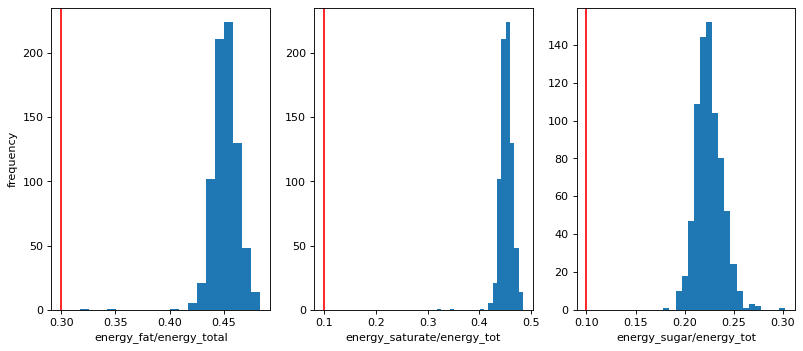

In [5]:
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.hist(df_rep["ratio_fat"], bins=20)
plt.xlabel("energy_fat/energy_total")
plt.ylabel("frequency")
plt.axvline(0.30,c="r")

plt.subplot(132)
plt.hist(df_rep["ratio_fat"], bins=20)
plt.xlabel("energy_saturate/energy_tot")
plt.axvline(0.10,c="r")

plt.subplot(133)
plt.hist(df_rep["ratio_sugar"], bins=20)
plt.xlabel("energy_sugar/energy_tot")
plt.axvline(0.10,c="r");

As we can see from the plots above non of the areas satisfy the recommandations by the WHO. Therefore we classify 50% of the areas which are closest to the recommandations as healthy. This will be done by k nearest neighbors. For this the ratios will be converted to a distance measure, ratio observed - recommandation value = distance from recommandation. Then we can take the 50% which are closest to 0 in the 4 features :distance_fat, distance_sugar, distance_saturated, alcohole

In [6]:
#creating the distance measures for the recommandations
def distance(nutrient,rec):
    return nutrient-rec
features = pd.DataFrame(columns=["distance_fat","distance_saturate","distance_sugar","alcohol"])
features["distance_fat"] = df_rep.apply(lambda row: distance(row["ratio_fat"],0.30), axis=1)
features["distance_saturate"] = df_rep.apply(lambda row: distance(row["ratio_saturate"],0.10), axis=1)
features["distance_sugar"] = df_rep.apply(lambda row: distance(row["ratio_sugar"],0.5), axis=1)
features["alcohol"] = df_rep["alcohol"]

In [7]:
#finding the nearest neigbors of the point [0,0,0,0]
from sklearn.neighbors import NearestNeighbors
half = int(len(features)/2)
optimum = np.array([0,0,0,0]).reshape(1, -1)
nbrs = NearestNeighbors(n_neighbors=half, algorithm='ball_tree').fit(features)
distances , indices = nbrs.kneighbors(optimum)

#crating healthy binary variabel base on the returned set from kneighbors
nearest_indices = indices.tolist()[0]

def healthy(index):
    return 1 if index in nearest_indices else 0

def rowIndex(row):
    return row.name

df_rep["rowIndex"] = df_rep.apply(lambda row: rowIndex(row), axis=1)
df_rep["healthy"] = df_rep.apply(lambda row: healthy(row["rowIndex"]), axis=1)

### 3. Propensity score matching
For the matching we use the package pymatcher which has the most important functions implemented


In [8]:
#creating the covariates for the propensity matching. These are all the demographic data from the tesco datasat + the imd score
healthy = df_rep[df_rep["healthy"]==1][["representativeness_norm","male","female","population","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]
unhealthy = df_rep[df_rep["healthy"]==0][["representativeness_norm","male","female","population","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]


Formula:
healthy ~ representativeness_norm+male+female+population+people_per_sq_km+avg_age+age_0_17+age_18_64+age_65+IMD19_SCORE
n majority: 379
n minority: 379
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 76.25%


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


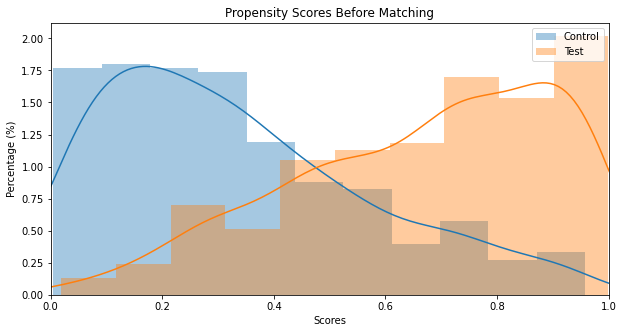

In [9]:
#Initiating the Matcher class Matcher and calculating 100 models log regression models
from pymatch.Matcher import Matcher
m = Matcher(healthy,unhealthy , yvar="healthy", exclude=[])
m.fit_scores(nmodels=100)
m.predict_scores()
m.plot_scores()

We see that the plots show seperability. The propensity scores for the test variable(healty areas) are way higher for the unhealthy areas. This is alsoe shwon with the average accuracy above 50% of 72%

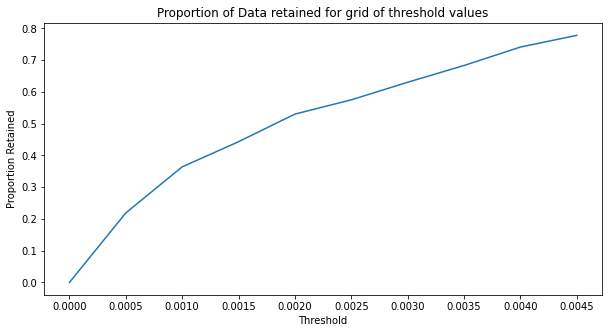

In [10]:
m.tune_threshold(method="random", rng=np.arange(0, .005, .0005))

Since our dataset is be design balance, 50% of the areas are classified as healthy and 50% healthy we need to find a good treshold. Because with a threshold of infity the propensity score would do nothing. So we have to tune it to get the best matching. We found that 0.025 gave the best matching.

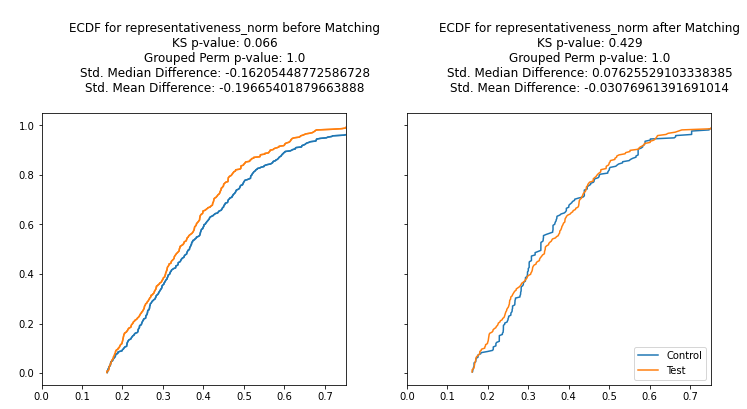

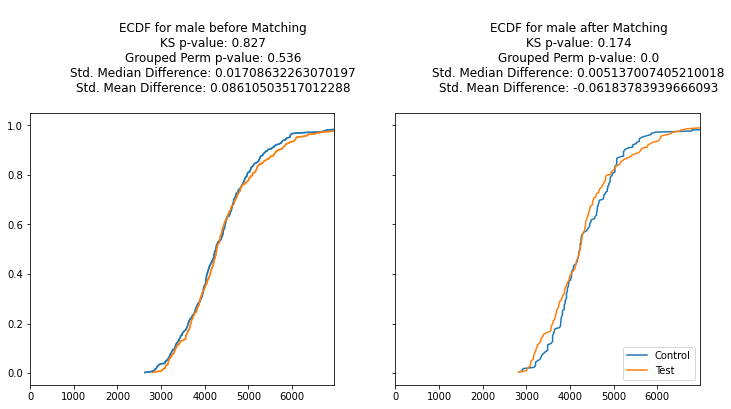

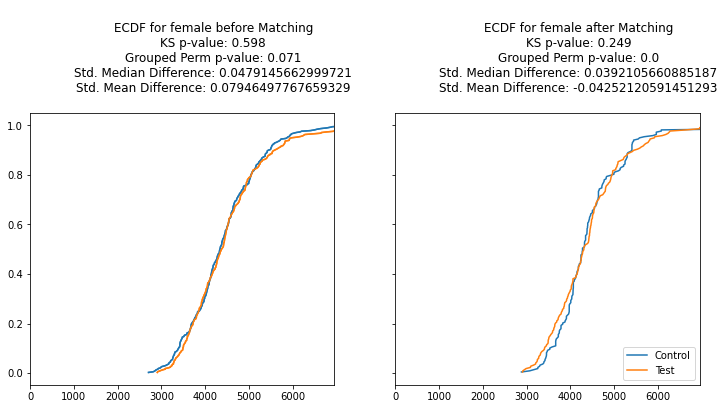

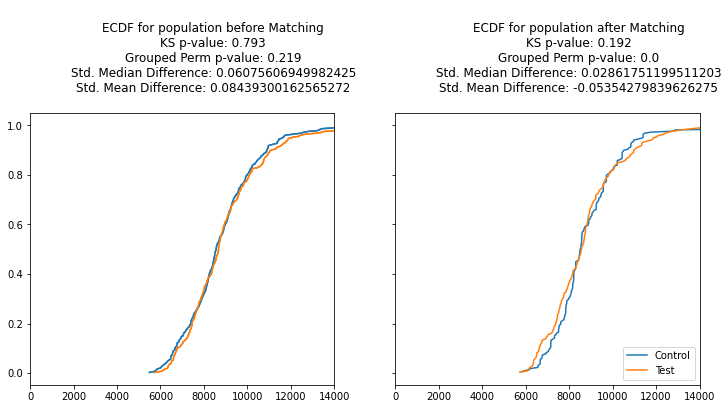

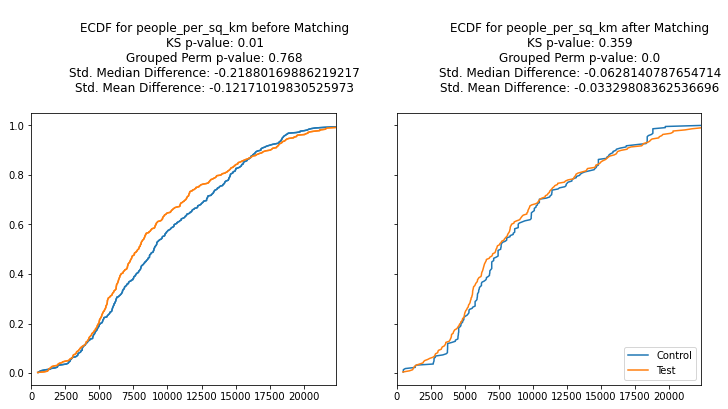

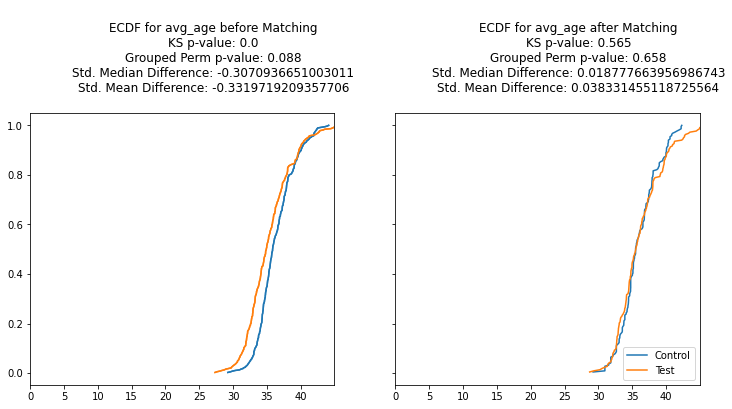

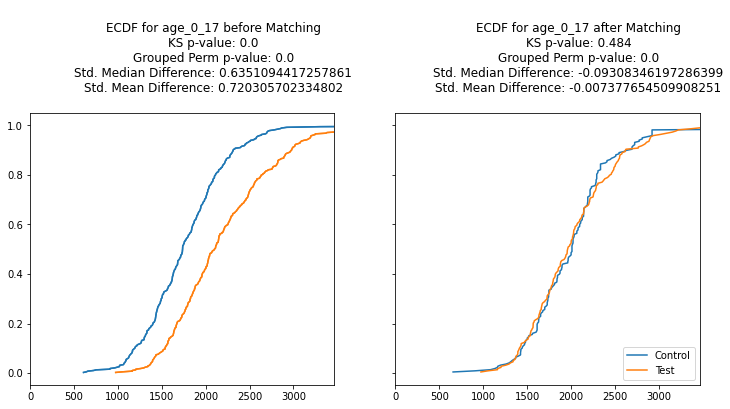

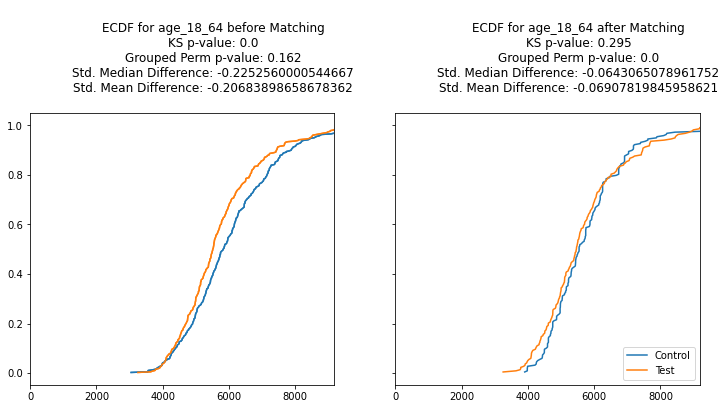

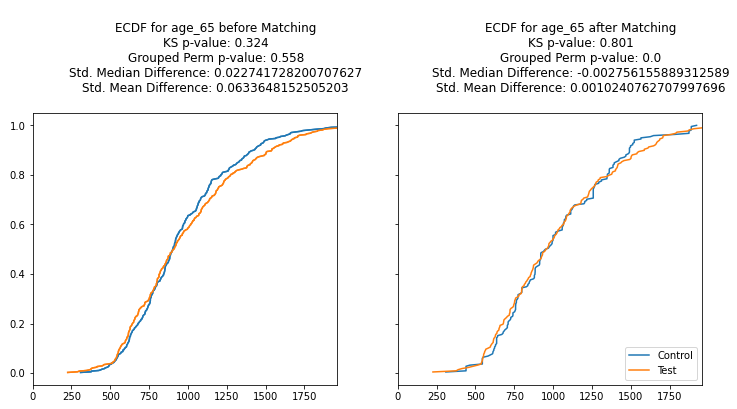

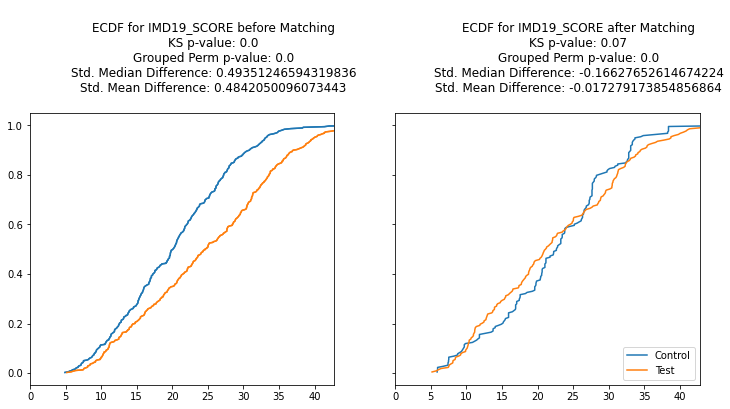

In [11]:
m.match(method="random", nmatches=1, threshold=0.0025) #the random flags means that if many points are in the threshold area a random one is chosen. We found this gives better results. because otherwise one point would be match 30 times because its matching with repetiton in the majority set.
cc = m.compare_continuous(return_table=True)

Now we have to check to see the quality of the matching. For that we use the plots of the estimator of the Cumulative Distribution Function and Kolmogorov-Smirnov Goodness of fit teast and the chi.square distance similarity. But first we focus on the plots. The goal is that both graphs are very close together. We can see that some graphs are alredy very close together before the matching. For example male, femal and population. This is by design of the msoa areas. Therefore we dont have to consider those during matching. We will redo the first steps without these covariates. 

Formula:
healthy ~ representativeness_norm+people_per_sq_km+avg_age+age_0_17+age_18_64+age_65+IMD19_SCORE
n majority: 379
n minority: 379
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 73.22%


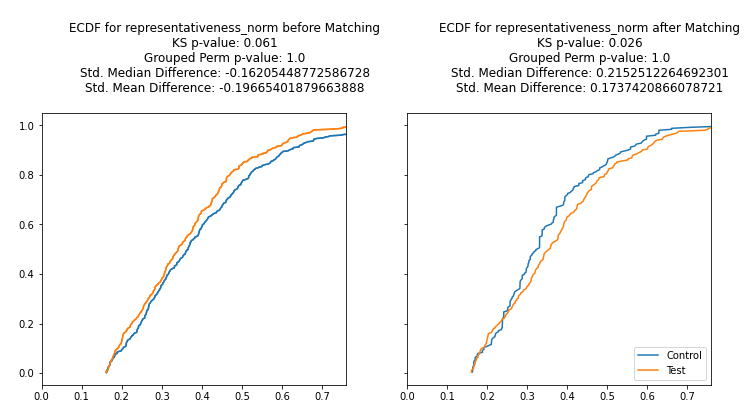

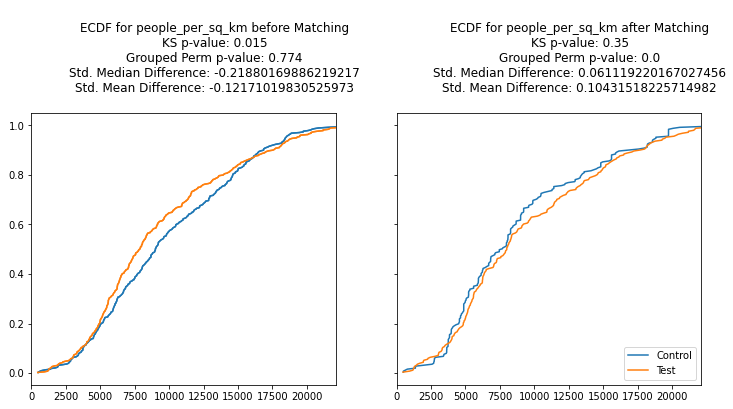

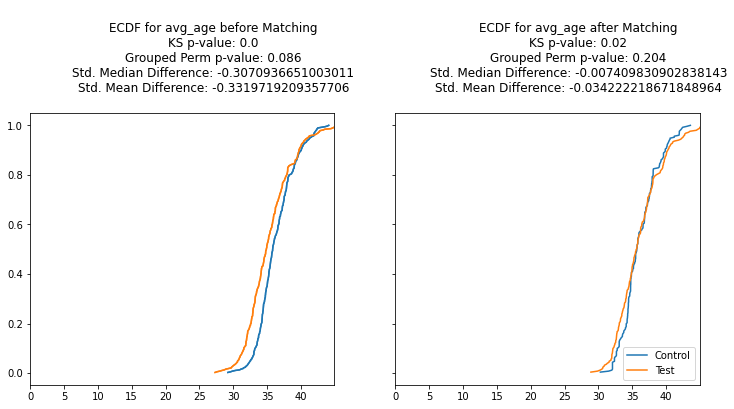

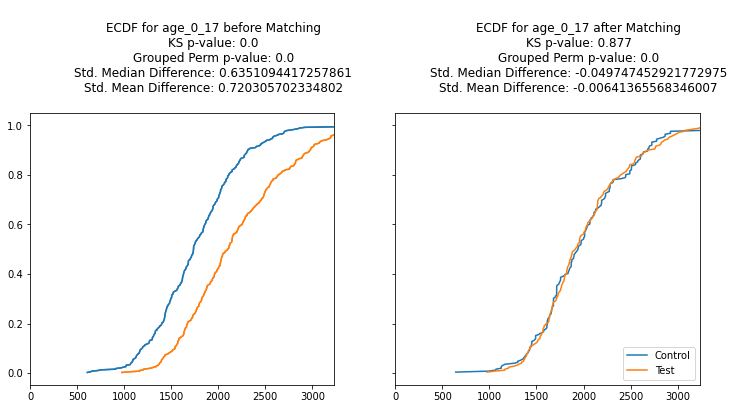

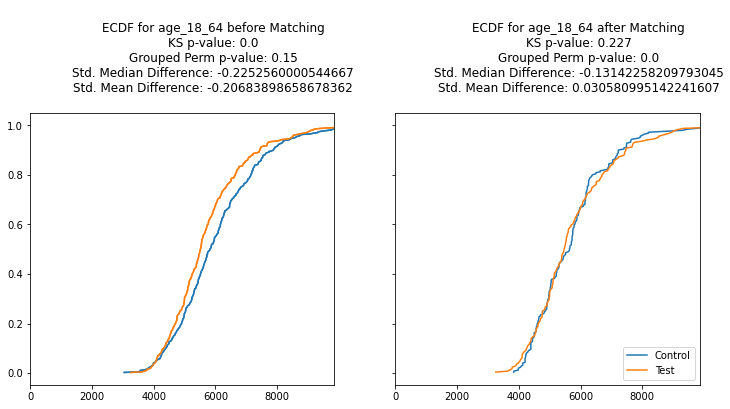

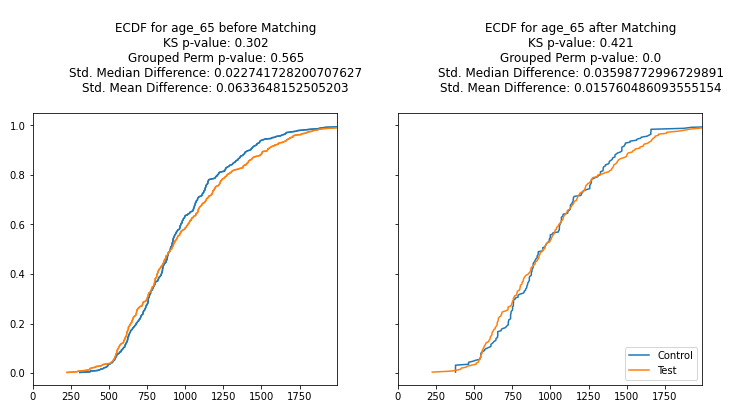

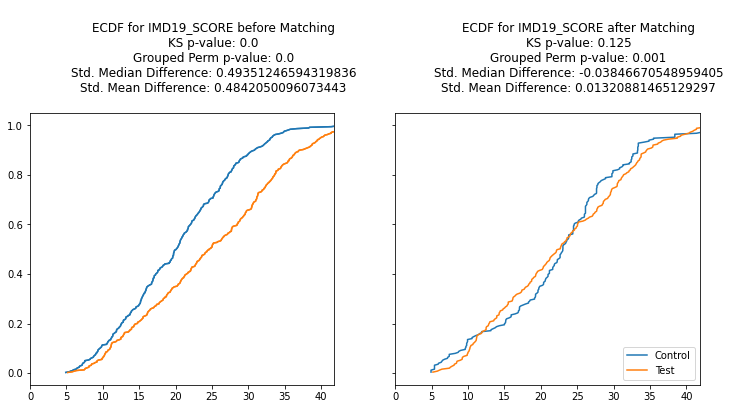

In [12]:
#creating the covariates for the propensity matching. This time without male, femal and population feature
healthy = df_rep[df_rep["healthy"]==1][["representativeness_norm","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]
unhealthy = df_rep[df_rep["healthy"]==0][["representativeness_norm","people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]

#Initiating the Matcher class Matcher and calculating 100 models log regression models
from pymatch.Matcher import Matcher
m = Matcher(healthy,unhealthy , yvar="healthy", exclude=[])
m.fit_scores(nmodels=100)
m.predict_scores()

m.match(method="random", nmatches=1, threshold=0.0025)
cc = m.compare_continuous(return_table=True)

In [13]:
print(((cc["ks_after"]>0.05).sum() - (cc["ks_before"]>0.05).sum()))
print(((cc["grouped_chisqr_after"]>0.05).sum() - (cc["grouped_chisqr_before"]>0.05).sum()))

3
-3


Now looking at the KS-test and the Chi-Square Distances we can compare how many distributions satisfiy the condition to be > 0.05. From the plot above we see that the KS-Test is improved for most of the distributions but the Chi-square distance is decreased for most distributions. We are a bit unsure why we observe this behavior or how to fix it. 

In [14]:
#Creating new dataframe with the matches and the origonal dataframe
df = pd.merge(df_rep,m.matched_data,how="left")
df_matched = (df[df["match_id"].notna()]).sort_values("match_id")
df_matched.head(6)

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,area_sq_km,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar,rowIndex,healthy,scores,match_id,record_id
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,2.14,5009.345794,0.444657,0.178014,0.260653,1,1,0.882918,0.0,0.0
389,E02000466,23.824340,10,E02000466,316.507137,25.0,120.0,220.0,400.0,1000.0,...,6.28,1364.331210,0.446791,0.178465,0.244397,345,0,0.883279,0.0,537.0
341,E02000415,27.363437,6,E02000415,392.839446,37.0,165.0,300.0,500.0,1000.0,...,0.70,10242.857143,0.454301,0.177861,0.216002,299,0,0.417788,10.0,520.0
20,E02000032,8.446301,6,E02000032,373.395385,32.5,151.0,296.0,500.0,1000.0,...,1.41,5468.794326,0.450067,0.177754,0.228044,20,1,0.416221,10.0,10.0
165,E02000240,29.908371,12,E02000240,379.029016,32.5,150.0,290.0,500.0,1000.0,...,1.72,5939.534884,0.446169,0.178389,0.237011,147,0,0.909789,13.0,436.0
25,E02000037,11.128158,14,E02000037,361.534523,32.5,150.0,280.0,465.0,1000.0,...,4.32,2248.148148,0.445787,0.178857,0.268411,25,1,0.911690,13.0,13.0


## 4. Comparing covid deaths for healthy/unhealthy MSOA's

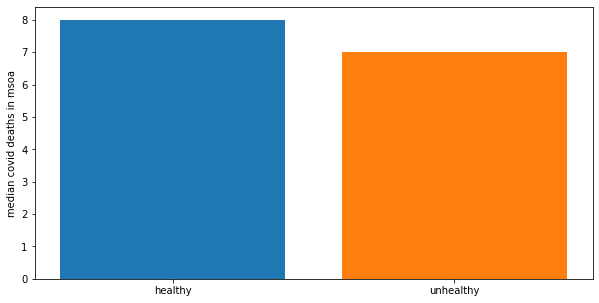

In [15]:
#creating plots of the median deaths in healthy areas vs unhealthy areas
fig, ax = plt.subplots()
healthy = statistics.median(df_matched[df_matched["healthy"]==1]["Covid_deaths_march_july"])
unhealthy = statistics.median(df_matched[df_matched["healthy"]==0]["Covid_deaths_march_july"])
ax = plt.bar("healthy",healthy)
ax = plt.bar("unhealthy",unhealthy)
plt.ylabel("median covid deaths in msoa");

We observe, that areas which eat less healthy according the who guidlines actually are less likely to die of corona. We can quantify this with the average treatment effect. 

In [16]:
ATE = 0
for match in list(df_matched["match_id"].unique()) :
    pair = df_matched[df_matched["match_id"]==match]
    healthy = pair[pair["healthy"]==1]
    unhealthy = pair[pair["healthy"]==0]

    ATE += healthy["Covid_deaths_march_july"].values[0]-unhealthy["Covid_deaths_march_july"].values[0]
print("The average treatment effect ist: {}".format(ATE))

The average treatment effect ist: 171


So fare whe have no explenation what the reason could be for this result it would be more intiutive that healthy areas have less covid deaths than unhealthy. On reason could be that the tesco dataset is not as relevant as we claimed it to be. A reason for that could be that many people have moved or the nutritional behavior have drastically changed. Another option would be to implement this method from K. Imai, M. Ratkovic. Which could lead to a better matching https://rss.onlinelibrary.wiley.com/doi/10.1111/rssb.12027

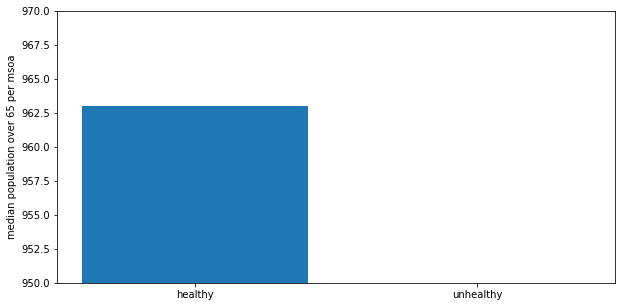

In [17]:
#creating plots of the average age in healthy areas vs unhealthy areas
fig, ax = plt.subplots()
ax.set_ylim(950, 970)
healthy = statistics.median(df_matched[df_matched["healthy"]==1]["age_65"])
unhealthy = statistics.median(df_matched[df_matched["healthy"]==0]["age_65"])
ax = plt.bar("healthy",healthy)
ax = plt.bar("unhealthy",unhealthy)
plt.ylabel("median population over 65 per msoa");

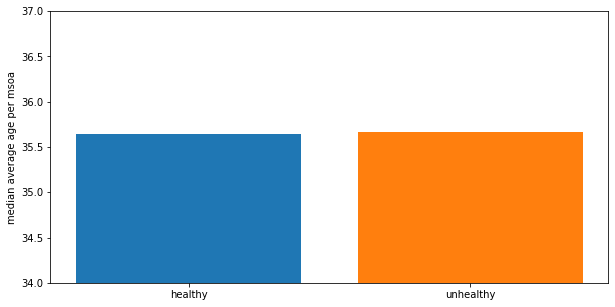

In [18]:
#creating plots of the median average age in healthy areas vs unhealthy areas
fig, ax = plt.subplots()
ax.set_ylim(34, 37)
healthy = statistics.median(df_matched[df_matched["healthy"]==1]["avg_age"])
unhealthy = statistics.median(df_matched[df_matched["healthy"]==0]["avg_age"])
ax = plt.bar("healthy",healthy)
ax = plt.bar("unhealthy",unhealthy)
plt.ylabel("median average age per msoa");

In [19]:
#Import list
import scipy
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model
from statsmodels.discrete.discrete_model import Logit, MNLogit
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [20]:
#Use of scikit library for boosted decision trees
#Builld gradient boosted decision regressor
#Add crosss validation to find hyperparameters.
def BoostedTree(X, y, train, test):
    model = GradientBoostingRegressor(learning_rate= .1, n_estimators = 100, max_depth = 3)
    model.fit(train[X], train[y])
    y_pred = model.predict(test[X])
    r2 = r2_score(test[y], y_pred)
    return model, r2

#Operates cross-validation for specified N-Fold and hyperparameters
def CrossVal(X, y, train, N=20, n_estimators=100, learning_rate=0.1, max_depth=3):
    model = GradientBoostingRegressor(learning_rate= learning_rate, n_estimators = n_estimators, max_depth = max_depth)
    r2s = cross_validate(model, train[X], train[y], scoring='r2', cv=N)['test_score']
    return np.asarray(r2s).mean()

#Function that finds the best set of parameters among the given lists based on a training set
#estimators : list of int, estimator
#learnings : list of learning rates
#depths : list of maximum depths of the tree
def FindHParams (X, y, train, estimators, learnings, depths, N=20):
    best_estimator = estimators[0]
    best_learning = learnings[0]
    best_depth = depths[0]
    best_r2mean = -1
    
    for estimator in estimators:
        for learning in learnings:
            for depth in depths:
                r2mean = CrossVal(X, y, train, N, estimator, learning, depth)
                
                if r2mean>best_r2mean:
                    best_r2mean = r2mean
                    best_estimator = estimator
                    best_learning = learning
                    best_depth = depth
    return best_estimator, best_learning, best_depth

## 5. Study variable dependence excluding healthy/unhealthy

Next we will try to build different regression models to determine which covariate has the most impact on Covid-19 deaths.
To do so, we will first study covariates excluding the newly calculated features healthy/unhealthy. We will stick with the possible independent variables from the paper. 

In [100]:
# Create gravity object
gravity_fn = lambda row: row['Covid_deaths_march_july'] / row['population'] # define a function for the new column
gravity_col = df_rep.apply(gravity_fn, axis=1) # get column data with an index
df_rep_gravity = df_rep.assign(col=gravity_col.values) # assign values to column 'c'
df_rep_gravity.columns = ['gravity' if x == 'col' else x for x in df_rep_gravity.columns] # rename

# Define variables
X_1 = ["IMD19_SCORE", "healthy"]
y_1 = ["gravity"]

X_2 = ["gravity", "healthy"]
y_2 = ["IMD19_SCORE"]

X_3 = ["IMD19_SCORE", "gravity"]
y_3 = ["healthy"]

features_set_1  = df_rep_gravity[X_1]
predictor_set_1 = df_rep_gravity[y_1].values.ravel()

features_set_2  = df_rep_gravity[X_2]
predictor_set_2 = df_rep_gravity[y_2].values.ravel()

features_set_3  = df_rep_gravity[X_3]
predictor_set_3 = df_rep_gravity[y_3].values.ravel()

def compare_methods(X, y, log=True):
    # Create regressor objects
    linear_regressor        = linear_model.LinearRegression()
    log_regressor           = linear_model.LogisticRegression(C=1e3, max_iter=5000)
    decision_tree_regressor = DecisionTreeRegressor(max_depth=4)
    adaboost_regressor      = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=8)
    
    # Linear regression
    linear_regressor.fit(X_train, y_train)
    print("Linear Regression score: " + str(linear_regressor.score(X_test, y_test)))
    
    # Logarithmic regression
    if log:
        log_regressor.fit(X_train, y_train)
        print("Log Regression score: " + str(log_regressor.score(X_test, y_test)))

    # Boosted Decision Tree
    decision_tree_regressor.fit(X_train, y_train)
    print("Decision Trees score: " + str(decision_tree_regressor.score(X_test, y_test)))

    # Adaboost
    adaboost_regressor.fit(X_train, y_train)
    print("Adaboost score: " + str(adaboost_regressor.score(X_test, y_test)))

print("=== Predicting Covid-19 Deaths ===")
compare_methods(features_set_1, predictor_set_1, log=False)
print("\n")

print("=== Predicting IMD19 Score ===")
compare_methods(features_set_2, predictor_set_2, log=False)
print("\n")

print("=== Predicting Healthiness ===")
compare_methods(features_set_3, predictor_set_3, log=True)
print("\n")

=== Predicting Covid-19 Deaths ===
Linear Regression score: -0.04865809952672384
Decision Trees score: -0.37931473561935936
Adaboost score: -0.6277841334960057


=== Predicting IMD19 Score ===
Linear Regression score: 0.14881497916313802
Decision Trees score: 0.12488348404383987
Adaboost score: 0.10018652732764266


=== Predicting Healthiness ===
Linear Regression score: 0.08896146494660129
Log Regression score: 0.7105263157894737
Decision Trees score: 0.05485762280575923
Adaboost score: 0.033125925890196806




In [232]:
# Decision trees for IMD19 is the most efficient model, but it only has 0.12 R2 score
best_regressor = DecisionTreeRegressor(max_depth=4)
best_model = best_regressor.fit(features_set_2, predictor_set_2)

    MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0  E12000007  London      7375      7187        188    25.5    4385   
1  E12000007  London      6775      6724         51    31.3    2713   
2  E12000007  London     10045     10033         12    46.9    3834   
3  E12000007  London      6182      5937        245    24.8    2318   
4  E12000007  London      8562      8562          0    72.1    3183   

   AVHHOLDSZ                                           geometry  
0        1.6  MULTIPOLYGON (((531667.624 180534.992, 531

(500655.0629999846, 564875.8130003222, 153596.657450073, 203187.74954846798)

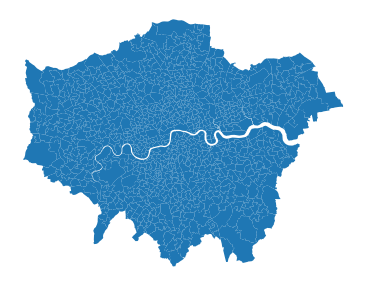

In [233]:
# Mapping
import geopandas as gpd

# set the filepath and load in a shapefile
map_fp = "Data/map_data/MSOA_2011_London_gen_MHW.shp"
map_df = gpd.read_file(map_fp)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
print(map_df.head())
axis = map_df.plot()
axis.axis('off')

    MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  ...  age_65  \
0  E12000007  London      7375      7187        188    25.5  ...  1320.0   
1  E12000007  London      6775      6724         51    31.3  ...     NaN   
2  E12000007  London     10045     10033         12    46.9  ...  1309.0   
3  E12000007  London      6182      5937        245    24.8  ...     NaN   
4  E12000007  London      8562      8562          0    72.1  ...     NaN   

     avg_age area_sq_km people_per_sq_km  ratio_fat  ratio_saturate  \
0  43.910124       2.

<AxesSubplot:>

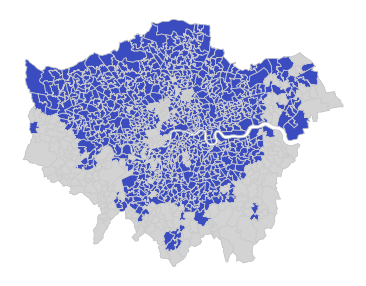

In [234]:
# Map data
mapped_df_rep_gravity = map_df.merge(df_rep_gravity, left_on='MSOA11CD', right_on='MSOAC', how='left')

# We see that we don't have data for all MSOAs
print(mapped_df_rep_gravity.head())
axis = map_df.plot()
axis.axis('off')

mapped_df_rep_gravity.plot(
    column='avg_age',
    vmin=1.,
    vmax=1.,
    cmap='coolwarm',
    linewidth=0.8,
    ax=axis,
    edgecolor='0.8',
    missing_kwds= dict(color = "lightgrey",),
)

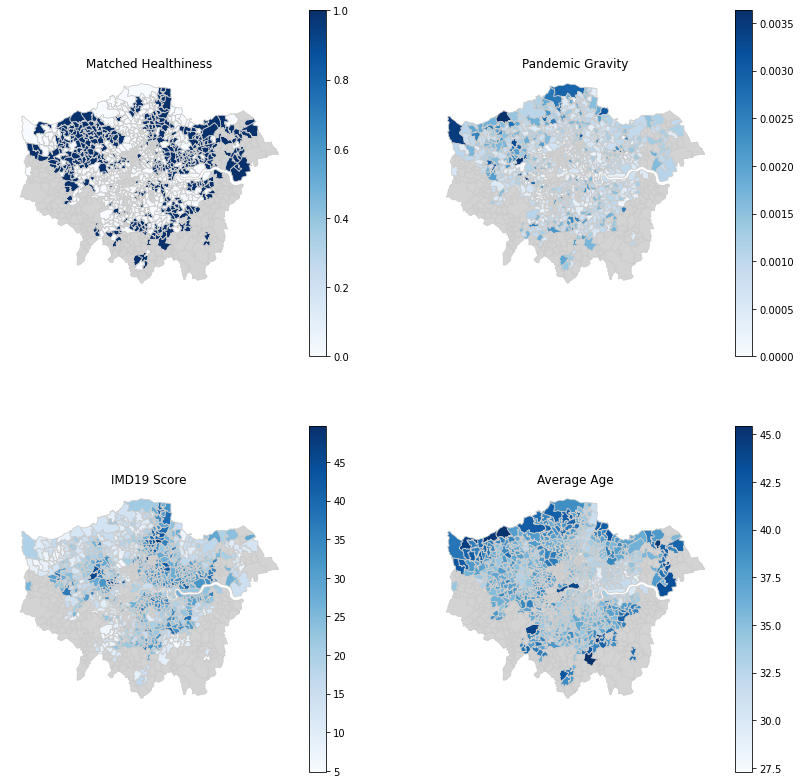

In [235]:
# Mapping time
# set a variable that will call whatever column we want to visualise on the map
variable_healthy      = 'healthy'
variable_healthy_pred = 'healthy_pred'
variable_gravity      = 'gravity'
variable_imd19        = 'IMD19_SCORE'
variable_avg_age      = 'avg_age'

# create figure and axes for Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

# helper function to plot maps in a standard way
def plot_map(plot_map_df, column_name, axis, title='', vmin=None, vmax=None):
    # remove the axes
    axis.axis('off')
    axis.set_title(title)
    
    # plot geopandas
    plot_map_df.plot(
        column=column_name,
        cmap='Blues',
        vmin=vmin,
        vmax=vmax,
        linewidth=0.8,
        ax=axis,
        edgecolor='0.8',
        missing_kwds= dict(color = "lightgrey",),
        legend=True
    )

# create maps
plot_map(mapped_df_rep_gravity, variable_healthy, ax1, 'Matched Healthiness')
plot_map(mapped_df_rep_gravity, variable_gravity, ax2, 'Pandemic Gravity')
plot_map(mapped_df_rep_gravity, variable_imd19,   ax3, 'IMD19 Score')
plot_map(mapped_df_rep_gravity, variable_avg_age, ax4, 'Average Age')

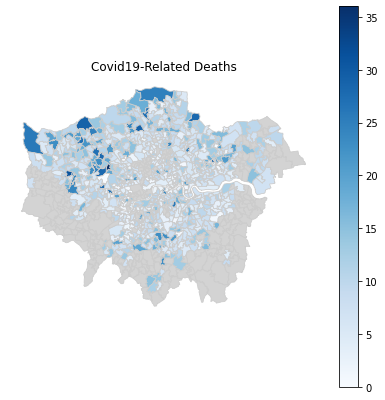

In [236]:
# Plot map of covid deaths
fig, axis = plt.subplots(1, figsize=(7, 7))
plot_map(mapped_df_rep_gravity, 'Covid_deaths_march_july', axis, 'Covid19-Related Deaths')

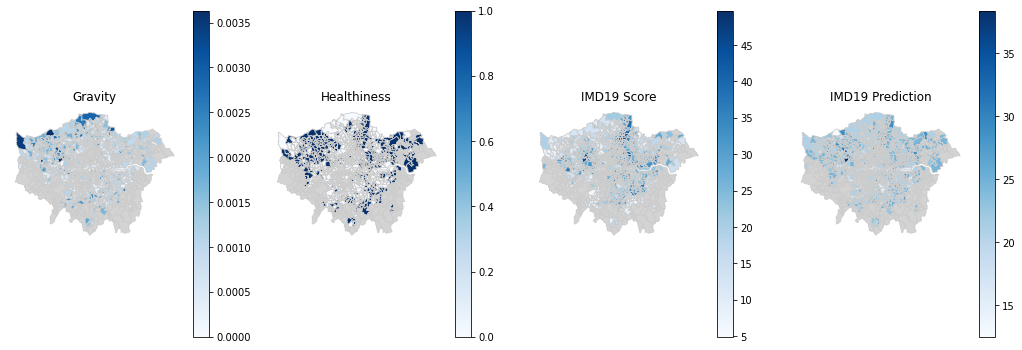

In [237]:
# This cell would have been used if we had good scores for the machine learning models
# Sadly, it is not the case. The cell remains for legacy.

import math
import contextily as ctx

# create figure and axes for Matplotlib
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6))

# remove the axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

def predict_imd19_row(row):
    if not math.isnan(row[variable_gravity]):
        return best_model.predict(np.array([row[variable_gravity], row[variable_healthy]]).reshape(1, -1))[0]
    else:
        return float('NaN')

def predict_healthy_row(row):
    if not math.isnan(row[variable_gravity]):
        return best_model.predict(np.array([row[variable_gravity], row[variable_imd19]]).reshape(1, -1))[0]
    else:
        return float('NaN')

# Create healthy_pred feature
pred_fn = lambda row: predict_imd19_row(row)
pred_col = mapped_df_rep_gravity.apply(pred_fn, axis=1)
mapped_df_rep_gravity = mapped_df_rep_gravity.assign(imd19_pred=pred_col.values)

# Plot maps
plot_map(mapped_df_rep_gravity, variable_gravity, ax1, 'Gravity')
plot_map(mapped_df_rep_gravity, variable_healthy, ax2, 'Healthiness')
plot_map(mapped_df_rep_gravity, variable_imd19,   ax3, 'IMD19 Score')
plot_map(mapped_df_rep_gravity, 'imd19_pred',     ax4, 'IMD19 Prediction')

In [238]:
# Create regression over all features but pandemic gravity
y_gravity = [variable_gravity]
X_gravity = ['healthy', 'IMD19_SCORE', 'weight', 'weight_perc2.5', 'weight_perc25', 'weight_perc50', 'weight_perc75', 'weight_perc97.5', 'weight_std', 'weight_ci95', 'volume', 'volume_perc2.5', 'volume_perc25', 'volume_perc50', 'volume_perc75', 'volume_perc97.5', 'volume_std', 'volume_ci95', 'fat', 'fat_perc2.5', 'fat_perc25', 'fat_perc50', 'fat_perc75', 'fat_perc97.5', 'fat_std', 'fat_ci95', 'saturate', 'saturate_perc2.5', 'saturate_perc25', 'saturate_perc50', 'saturate_perc75', 'saturate_perc97.5', 'saturate_std', 'saturate_ci95', 'salt', 'salt_perc2.5', 'salt_perc25', 'salt_perc50', 'salt_perc75', 'salt_perc97.5', 'salt_std', 'salt_ci95', 'sugar', 'sugar_perc2.5', 'sugar_perc25', 'sugar_perc50', 'sugar_perc75', 'sugar_perc97.5', 'sugar_std', 'sugar_ci95', 'protein', 'protein_perc2.5', 'protein_perc25', 'protein_perc50', 'protein_perc75', 'protein_perc97.5', 'protein_std', 'protein_ci95', 'carb', 'carb_perc2.5', 'carb_perc25', 'carb_perc50', 'carb_perc75', 'carb_perc97.5', 'carb_std', 'carb_ci95', 'fibre', 'fibre_perc2.5', 'fibre_perc25', 'fibre_perc50', 'fibre_perc75', 'fibre_perc97.5', 'fibre_std', 'fibre_ci95', 'alcohol', 'alcohol_perc2.5', 'alcohol_perc25', 'alcohol_perc50', 'alcohol_perc75', 'alcohol_perc97.5', 'alcohol_std', 'alcohol_ci95', 'energy_fat', 'energy_fat_perc2.5', 'energy_fat_perc25', 'energy_fat_perc50', 'energy_fat_perc75', 'energy_fat_perc97.5', 'energy_fat_std', 'energy_fat_ci95', 'energy_saturate', 'energy_saturate_perc2.5', 'energy_saturate_perc25', 'energy_saturate_perc50', 'energy_saturate_perc75', 'energy_saturate_perc97.5', 'energy_saturate_std', 'energy_saturate_ci95', 'energy_sugar', 'energy_sugar_perc2.5', 'energy_sugar_perc25', 'energy_sugar_perc50', 'energy_sugar_perc75', 'energy_sugar_perc97.5', 'energy_sugar_std', 'energy_sugar_ci95', 'energy_protein', 'energy_protein_perc2.5', 'energy_protein_perc25', 'energy_protein_perc50', 'energy_protein_perc75', 'energy_protein_perc97.5', 'energy_protein_std', 'energy_protein_ci95', 'energy_carb', 'energy_carb_perc2.5', 'energy_carb_perc25', 'energy_carb_perc50', 'energy_carb_perc75', 'energy_carb_perc97.5', 'energy_carb_std', 'energy_carb_ci95', 'energy_fibre', 'energy_fibre_perc2.5', 'energy_fibre_perc25', 'energy_fibre_perc50', 'energy_fibre_perc75', 'energy_fibre_perc97.5', 'energy_fibre_std', 'energy_fibre_ci95', 'energy_alcohol', 'energy_alcohol_perc2.5', 'energy_alcohol_perc25', 'energy_alcohol_perc50', 'energy_alcohol_perc75', 'energy_alcohol_perc97.5', 'energy_alcohol_std', 'energy_alcohol_ci95', 'energy_tot', 'energy_tot_perc2.5', 'energy_tot_perc25', 'energy_tot_perc50', 'energy_tot_perc75', 'energy_tot_perc97.5', 'energy_tot_std', 'energy_tot_ci95', 'f_energy_fat', 'f_energy_saturate', 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol', 'energy_density', 'h_nutrients_weight', 'h_nutrients_weight_norm', 'h_nutrients_calories', 'h_nutrients_calories_norm', 'f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine', 'f_dairy_weight', 'f_eggs_weight', 'f_fats_oils_weight', 'f_fish_weight', 'f_fruit_veg_weight', 'f_grains_weight', 'f_meat_red_weight', 'f_poultry_weight', 'f_readymade_weight', 'f_sauces_weight', 'f_sweets_weight', 'h_items', 'h_items_norm', 'h_items_weight', 'h_items_weight_norm', 'representativeness_norm', 'transaction_days', 'num_transactions', 'man_day', 'population', 'male', 'female', 'age_0_17', 'age_18_64', 'age_65', 'avg_age', 'area_sq_km', 'people_per_sq_km', 'ratio_fat', 'ratio_saturate', 'ratio_sugar']

features_set  = mapped_df_rep_gravity[X_gravity].dropna()
predictor_set = mapped_df_rep_gravity[y_gravity].dropna().values.ravel()

# Create regressor objects
linear_regressor        = linear_model.LinearRegression()
decision_tree_regressor = DecisionTreeRegressor(max_depth=25)
adaboost_regressor      = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25), n_estimators=600)

X_train, X_test, y_train, y_test = train_test_split(features_set, predictor_set, test_size=0.01, random_state=8)
    
# Linear regression
linear_regressor.fit(X_train, y_train)
print("Linear Regression score: " + str(linear_regressor.score(X_test, y_test)))

# Boosted Decision Tree
decision_tree_regressor.fit(X_train, y_train)
print("Decision Trees score: " + str(decision_tree_regressor.score(X_test, y_test)))

# Adaboost
adaboost_regressor.fit(X_train, y_train)
print("Adaboost score: " + str(adaboost_regressor.score(X_test, y_test)))

Linear Regression score: 0.2819829402797922
Decision Trees score: 0.5521399112528371
Adaboost score: 0.4708149003315444


In [239]:
# Train best model
# AdaBoostRegressor(DecisionTreeRegressor(max_depth=25), n_estimators=600)
# linear_model.LinearRegression()
# DecisionTreeRegressor(max_depth=25)
best_regressor = linear_model.LinearRegression()
best_regressor.fit(features_set, predictor_set)

LinearRegression()

In [240]:
import ipywidgets as widgets
from IPython.display import display, Javascript

pd.options.mode.chained_assignment = None

simulation_df = mapped_df_rep_gravity
df_features_bak = simulation_df[X_gravity]
simulation_df['gravity_pred'] = simulation_df['gravity']
simulation_df['gravity_pred_dist'] = simulation_df['gravity_pred'] - simulation_df['gravity']

avg_age_factor = 1.
imd19_score_factor = 1.
energy_density_factor = 1.
h_nutrients_calories_factor = 1.
f_fruit_veg_factor = 1.
f_readymade_factor = 1.
f_sauces_factor = 1.
f_soft_drinks_factor = 1.
people_per_sq_km_factor = 1.

# todo: sliders for features
def update(column, factor):
    df_features = df_features_bak
    df_features[column] = mapped_df_rep_gravity[column] * factor
    df_features_droppedna = df_features.dropna()
    df_features_droppedna['gravity_pred'] = best_regressor.predict(df_features_droppedna)
    df_features_droppedna['gravity_pred'] = np.where(df_features_droppedna['gravity_pred'] < 0, 0, df_features_droppedna['gravity_pred'])
    
    i = df_features_droppedna.index.intersection(simulation_df.index)
    j = df_features_droppedna.columns.intersection(simulation_df.columns)
    simulation_df.loc[i, j] = df_features_droppedna.loc[i, j]
    simulation_df['gravity_pred_dist'] = simulation_df['gravity_pred'] - simulation_df['gravity']
    
def update_avg_age(avg_age_factor = 1.0):
    update('avg_age', avg_age_factor)
    
def update_imd19(imd19_factor = 1.0):
    update('IMD19_SCORE', imd19_factor)
    
def update_nrj_density(nrj_density_factor = 1.0):
    update('energy_density', nrj_density_factor)
    
def update_calories(calories_factor = 1.0):
    update('h_nutrients_calories', calories_factor)
    
def update_f_fruit_veg(f_fruit_veg_factor = 1.0):
    update('f_fruit_veg', f_fruit_veg_factor)
    
def update_f_sauces(f_sauces_factor = 1.0):
    update('f_sauces', f_sauces_factor)
    
def update_people_per_sq_km(people_per_sq_km_factor = 1.0):
    update('people_per_sq_km', people_per_sq_km_factor)

widgets.interact(update_avg_age)
widgets.interact(update_imd19)
widgets.interact(update_nrj_density)
widgets.interact(update_calories)
widgets.interact(update_f_fruit_veg)
widgets.interact(update_f_sauces)
widgets.interact(update_people_per_sq_km)

interactive(children=(FloatSlider(value=1.0, description='avg_age_factor', max=3.0, min=-1.0), Output()), _dom…

interactive(children=(FloatSlider(value=1.0, description='imd19_factor', max=3.0, min=-1.0), Output()), _dom_c…

interactive(children=(FloatSlider(value=1.0, description='nrj_density_factor', max=3.0, min=-1.0), Output()), …

interactive(children=(FloatSlider(value=1.0, description='calories_factor', max=3.0, min=-1.0), Output()), _do…

interactive(children=(FloatSlider(value=1.0, description='f_fruit_veg_factor', max=3.0, min=-1.0), Output()), …

interactive(children=(FloatSlider(value=1.0, description='f_sauces_factor', max=3.0, min=-1.0), Output()), _do…

interactive(children=(FloatSlider(value=1.0, description='people_per_sq_km_factor', max=3.0, min=-1.0), Output…

<function __main__.update_people_per_sq_km(people_per_sq_km_factor=1.0)>

In [241]:
button = widgets.Button(description="Simulate Pandemic!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+3)'))

button.on_click(on_button_clicked)

Button(description='Simulate Pandemic!', style=ButtonStyle())

Output()

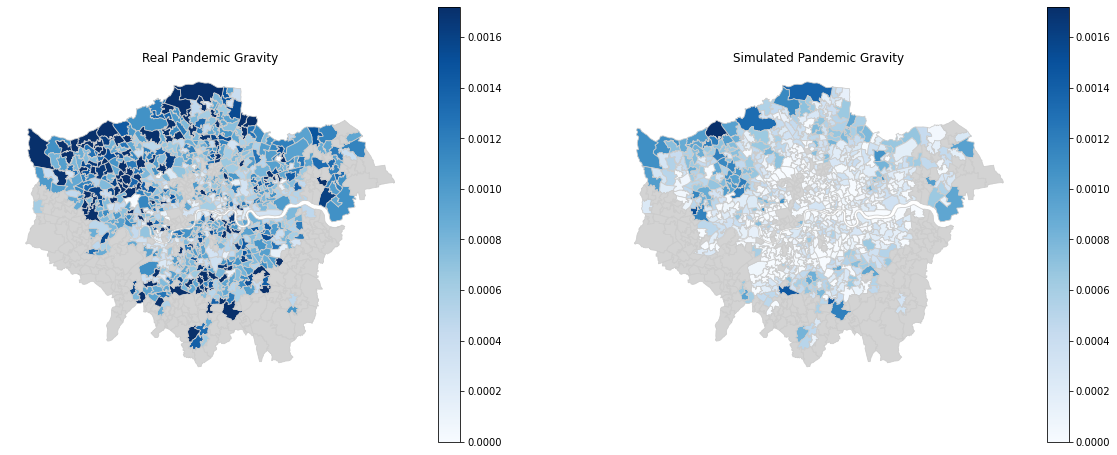

In [246]:
# create figure and axes for Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 8))
plt.ion()

max_gravity = simulation_df['gravity'].max()
max_gravity_pred = simulation_df['gravity_pred'].max()

if max_gravity < max_gravity_pred:
    max_gravity = max_gravity_pred

plot_map(simulation_df, variable_gravity, ax1, 'Real Pandemic Gravity', 0., max_gravity_pred)
plot_map(simulation_df, 'gravity_pred', ax2, 'Simulated Pandemic Gravity', 0., max_gravity_pred)

<AxesSubplot:title={'center':'Distance from Simulation to Reality'}>

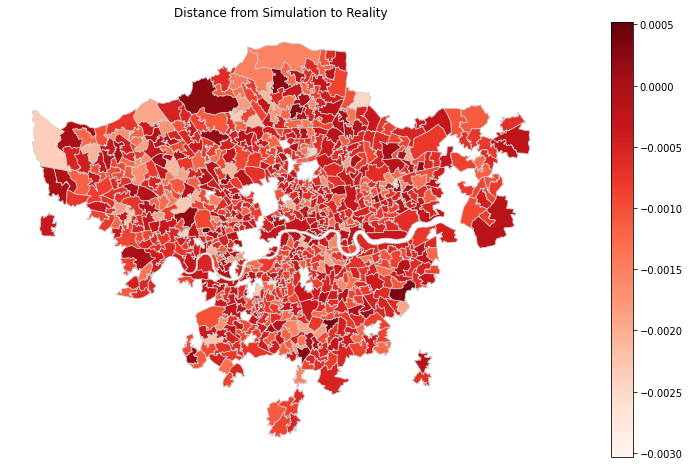

In [247]:
import matplotlib.colors as mcolors

fig, axis = plt.subplots(1, 1, figsize=(20, 8))
axis.axis('off')
axis.set_title('Distance from Simulation to Reality')
simulation_df.plot(column='gravity_pred_dist', cmap='Reds', linewidth=0.8, ax=axis, edgecolor='0.8', legend=True)